In [110]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D
from keras.layers import  BatchNormalization, LeakyReLU, Dropout, Activation

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [88]:
syscalls = [
    "sys_enter_setgroups",
    "sys_enter_sethostname",
    "sys_enter_accept",
    "sys_enter_lseek",
    "sys_enter_setitimer",
    "sys_enter_accept4",
    "sys_enter_setns",
    "sys_enter_acct",
    "sys_enter_madvise",
    "sys_enter_setpgid",
    "sys_enter_add_key",
    "sys_enter_mbind",
    "sys_enter_setpriority",
    "sys_enter_adjtimex",
    "sys_enter_membarrier",
    "sys_enter_setregid",
    "sys_enter_arm64_personality",
    "sys_enter_memfd_create",
    "sys_enter_setresgid",
    "sys_enter_bind",
    "sys_enter_memfd_secret",
    "sys_enter_setresuid",
    "sys_enter_bpf",
    "sys_enter_setreuid",
    "sys_enter_brk",
    "sys_enter_mincore",
    "sys_enter_setrlimit",
    "sys_enter_capget",
    "sys_enter_mkdirat",
    "sys_enter_setsid",
    "sys_enter_capset",
    "sys_enter_mknodat",
    "sys_enter_setsockopt",
    "sys_enter_chdir",
    "sys_enter_mlock",
    "sys_enter_settimeofday",
    "sys_enter_chroot",
    "sys_enter_setuid",
    "sys_enter_clock_adjtime",
    "sys_enter_mlockall",
    "sys_enter_setxattr",
    "sys_enter_clock_getres",
    "sys_enter_mmap",
    "sys_enter_shmat",
    "sys_enter_clock_gettime",
    "sys_enter_mount",
    "sys_enter_shmctl",
    "sys_enter_clock_nanosleep",
    "sys_enter_shmdt",
    "sys_enter_clock_settime",
    "sys_enter_shmget",
    "sys_enter_clone",
    "sys_enter_move_pages",
    "sys_enter_shutdown",
    "sys_enter_clone3",
    "sys_enter_mprotect",
    "sys_enter_sigaltstack",
    "sys_enter_close",
    "sys_enter_mq_getsetattr",
    "sys_enter_signalfd4",
    "sys_enter_close_range",
    "sys_enter_mq_notify",
    "sys_enter_socket",
    "sys_enter_connect",
    "sys_enter_mq_open",
    "sys_enter_socketpair",
    "sys_enter_copy_file_range",
    "sys_enter_mq_timedreceive",
    "sys_enter_splice",
    "sys_enter_delete_module",
    "sys_enter_mq_timedsend",
    "sys_enter_statfs",
    "sys_enter_dup",
    "sys_enter_mq_unlink",
    "sys_enter_statx",
    "sys_enter_dup3",
    "sys_enter_mremap",
    "sys_enter_swapoff",
    "sys_enter_epoll_create1",
    "sys_enter_msgctl",
    "sys_enter_swapon",
    "sys_enter_epoll_ctl",
    "sys_enter_msgget",
    "sys_enter_symlinkat",
    "sys_enter_epoll_pwait",
    "sys_enter_msgrcv",
    "sys_enter_sync",
    "sys_enter_epoll_pwait2",
    "sys_enter_msgsnd",
    "sys_enter_sync_file_range",
    "sys_enter_eventfd2",
    "sys_enter_msync",
    "sys_enter_syncfs",
    "sys_enter_execve",
    "sys_enter_munlock",
    "sys_enter_sysinfo",
    "sys_enter_execveat",
    "sys_enter_munlockall",
    "sys_enter_syslog",
    "sys_enter_exit",
    "sys_enter_munmap",
    "sys_enter_tee",
    "sys_enter_exit_group",
    "sys_enter_tgkill",
    "sys_enter_faccessat",
    "sys_enter_nanosleep",
    "sys_enter_timer_create",
    "sys_enter_faccessat2",
    "sys_enter_newfstat",
    "sys_enter_timer_delete",
    "sys_enter_fadvise64_64",
    "sys_enter_newfstatat",
    "sys_enter_timer_getoverrun",
    "sys_enter_fallocate",
    "sys_enter_newuname",
    "sys_enter_timer_gettime",
    "sys_enter_fanotify_init",
    "sys_enter_timer_settime",
    "sys_enter_fanotify_mark",
    "sys_enter_timerfd_create",
    "sys_enter_fchdir",
    "sys_enter_openat",
    "sys_enter_timerfd_gettime",
    "sys_enter_fchmod",
    "sys_enter_openat2",
    "sys_enter_timerfd_settime",
    "sys_enter_fchmodat",
    "sys_enter_times",
    "sys_enter_fchown",
    "sys_enter_tkill",
    "sys_enter_fchownat",
    "sys_enter_truncate",
    "sys_enter_fcntl",
    "sys_enter_umask",
    "sys_enter_fdatasync",
    "sys_enter_pipe2",
    "sys_enter_umount",
    "sys_enter_fgetxattr",
    "sys_enter_unlinkat",
    "sys_enter_finit_module",
    "sys_enter_unshare",
    "sys_enter_flistxattr",
    "sys_enter_prctl",
    "sys_enter_flock",
    "sys_enter_pread64",
    "sys_enter_utimensat",
    "sys_enter_fremovexattr",
    "sys_enter_preadv",
    "sys_enter_vhangup",
    "sys_enter_fsconfig",
    "sys_enter_preadv2",
    "sys_enter_vmsplice",
    "sys_enter_fsetxattr",
    "sys_enter_prlimit64",
    "sys_enter_wait4",
    "sys_enter_fsmount",
    "sys_enter_waitid",
    "sys_enter_fsopen",
    "sys_enter_fspick",
    "sys_enter_writev",
    "sys_enter_fstatfs",
    "sys_enter_fsync",
    "sys_enter_pselect6",
    "sys_enter_ftruncate",
    "sys_enter_ptrace",
    "sys_enter_futex",
    "sys_enter_pwrite64",
    "sys_enter_get_mempolicy",
    "sys_enter_pwritev",
    "sys_enter_get_robust_list",
    "sys_enter_pwritev2",
    "sys_enter_getcpu",
    "sys_enter_quotactl",
    "sys_enter_getcwd",
    "sys_enter_quotactl_fd",
    "sys_enter_getdents64",
    "sys_enter_getegid",
    "sys_enter_readahead",
    "sys_enter_geteuid",
    "sys_enter_readlinkat",
    "sys_enter_getgid",
    "sys_enter_readv",
    "sys_enter_getgroups",
    "sys_enter_reboot",
    "sys_enter_getitimer",
    "sys_enter_recvfrom",
    "sys_enter_getpeername",
    "sys_enter_recvmmsg",
    "sys_enter_getpgid",
    "sys_enter_remap_file_pages",
    "sys_enter_getppid",
    "sys_enter_removexattr",
    "sys_enter_getpriority",
    "sys_enter_renameat",
    "sys_enter_getrandom",
    "sys_enter_renameat2",
    "sys_enter_getresgid",
    "sys_enter_request_key",
    "sys_enter_getresuid",
    "sys_enter_restart_syscall",
    "sys_enter_getrlimit",
    "sys_enter_rseq",
    "sys_enter_getrusage",
    "sys_enter_getsid",
    "sys_enter_rt_sigpending",
    "sys_enter_getsockname",
    "sys_enter_getsockopt",
    "sys_enter_rt_sigqueueinfo",
    "sys_enter_gettid",
    "sys_enter_rt_sigreturn",
    "sys_enter_gettimeofday",
    "sys_enter_rt_sigsuspend",
    "sys_enter_getuid",
    "sys_enter_rt_sigtimedwait",
    "sys_enter_getxattr",
    "sys_enter_rt_tgsigqueueinfo",
    "sys_enter_init_module",
    "sys_enter_sched_get_priority_max",
    "sys_enter_inotify_add_watch",
    "sys_enter_sched_get_priority_min",
    "sys_enter_inotify_init1",
    "sys_enter_sched_getaffinity",
    "sys_enter_inotify_rm_watch",
    "sys_enter_sched_getattr",
    "sys_enter_sched_getparam",
    "sys_enter_sched_getscheduler",
    "sys_enter_sched_rr_get_interval",
    "sys_enter_sched_setaffinity",
    "sys_enter_sched_setattr",
    "sys_enter_sched_setparam",
    "sys_enter_sched_setscheduler",
    "sys_enter_sched_yield",
    "sys_enter_seccomp",
    "sys_enter_semctl",
    "sys_enter_ioprio_get",
    "sys_enter_semget",
    "sys_enter_ioprio_set",
    "sys_enter_semop",
    "sys_enter_kcmp",
    "sys_enter_semtimedop",
    "sys_enter_sendfile64",
    "sys_enter_sendmmsg",
    "sys_enter_keyctl",
    "sys_enter_kill",
    "sys_enter_sendto",
    "sys_enter_set_mempolicy",
    "sys_enter_set_robust_list",
    "sys_enter_set_tid_address",
    "sys_enter_setdomainname",
    "sys_enter_linkat",
    "sys_enter_setfsgid",
    "sys_enter_listen",
    "sys_enter_setfsuid",
    "sys_enter_listxattr",
    "sys_enter_setgid",
]

In [89]:


NUM_CLASSES = 2
CLASSES = np.array(['benign', 'malware'])
DATASET_DIR = "dataset/"
VECTOR_LENGTH = 32 * 32

label_encoder = LabelEncoder()
label_encoder.fit(syscalls)

def csvToVector(file_path):
    data = pd.read_csv(file_path)
    data_encoded = label_encoder.fit_transform(data['SYSTEM_CALL'])
    vector = np.zeros(VECTOR_LENGTH, dtype=np.uint8)
    syscall_nums = min(len(data_encoded), VECTOR_LENGTH)
    vector[:syscall_nums] = data_encoded[:syscall_nums]

    return vector

def load_data(dataset_dir):
    x = []
    y = []

    classes = [class_name for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name))]
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.csv'):
                file_path = os.path.join(class_dir, file_name)
                vector = csvToVector(file_path)
                x.append(vector)
                y.append(class_idx)
                
    x = np.array(x)
    y = np.array(y)
    return x, y


In [90]:
X, y = load_data(DATASET_DIR)

In [91]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [92]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(245, 1024)
(132, 1024)
(62, 1024)
(245, 2)
(132, 2)
(62, 2)


In [93]:
input_layer = Input(shape=(VECTOR_LENGTH, 1))

x = Conv1D(filters=32, kernel_size=3, padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Flatten()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [94]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1024, 1)]         0         
                                                                 
 conv1d_22 (Conv1D)          (None, 1024, 32)          128       
                                                                 
 batch_normalization_30 (Bat  (None, 1024, 32)         128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 1024, 32)          0         
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 512, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 512, 64)           6208

## Check Point

In [104]:
cp = ModelCheckpoint(
    filepath='CNN_1D_CheckPoint.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [106]:
model.fit(X_train, 
          y_train,
          validation_data=(X_val, y_val),
          batch_size=32, 
          epochs=1000, 
          shuffle=True,
          callbacks=[cp]
)

Epoch 1/1000
7/8 [=========================>....] - ETA: 0s - loss: 0.0487 - accuracy: 0.9777
Epoch 1: val_accuracy improved from -inf to 0.54839, saving model to CNN_1D_CheckPoint.h5
8/8 [==============================] - 1s 80ms/step - loss: 0.0479 - accuracy: 0.9755 - val_loss: 1.6342 - val_accuracy: 0.5484
Epoch 2/1000
7/8 [=========================>....] - ETA: 0s - loss: 0.0485 - accuracy: 0.9732
Epoch 2: val_accuracy improved from 0.54839 to 0.79032, saving model to CNN_1D_CheckPoint.h5
8/8 [==============================] - 1s 68ms/step - loss: 0.0521 - accuracy: 0.9714 - val_loss: 0.5972 - val_accuracy: 0.7903
Epoch 3/1000
7/8 [=========================>....] - ETA: 0s - loss: 0.0525 - accuracy: 0.9688
Epoch 3: val_accuracy improved from 0.79032 to 0.82258, saving model to CNN_1D_CheckPoint.h5
8/8 [==============================] - 0s 62ms/step - loss: 0.0543 - accuracy: 0.9673 - val_loss: 0.5604 - val_accuracy: 0.8226
Epoch 4/1000
7/8 [=========================>....] - ETA: 0

In [107]:
model.evaluate(X_test, y_test, batch_size=1000)

1/1 [==============================] - 0s 93ms/step - loss: 0.5059 - accuracy: 0.8864


[0.5058622360229492, 0.8863636255264282]

In [108]:
#model.save("CNN_1D_88ACCRY.h5")

In [111]:
cp_model = load_model('CNN_1D_CHeckPoint.h5')
cp_model.evaluate(X_test, y_test, batch_size=1000)

1/1 [==============================] - 1s 614ms/step - loss: 0.6202 - accuracy: 0.9091


[0.6201775074005127, 0.9090909361839294]

In [98]:
y_pred = model.predict(X_test)

5/5 [==============================] - 1s 46ms/step


In [99]:
preds_single = CLASSES[np.argmax(y_pred, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

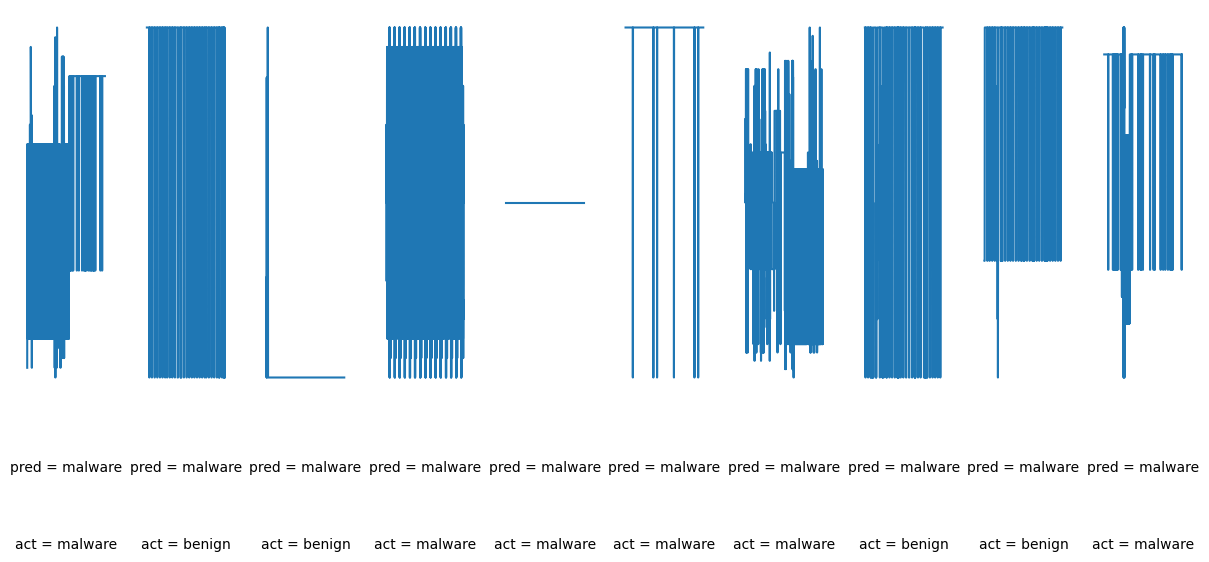

In [100]:
n_to_show = 10
indices = np.random.choice(range(len(X_test)), n_to_show)

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    data = X_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.plot(data)
    ax.axis('off')
    ax.text(0.5, -0.2, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.4, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)

plt.show()
